# Ensembling Feature Overview
Ensembling is a fancy name for sub-sampling the data and generating $n_\text{models}$ from regressing onto each of these sub-samples. In practice this helps to robustify the regressions against outliers and other issues. We highly recommend checking out the following paper for understanding the usefulness of these methods against noisy data: 
#### Fasel, U., Kutz, J. N., Brunton, B. W., & Brunton, S. L. (2022). Ensemble-SINDy: Robust sparse model discovery in the low-data, high-noise limit, with active learning and control. Proceedings of the Royal Society A, 478(2260), 20210904. https://arxiv.org/abs/2111.10992

This notebook provides an overview of the basic and advanced functionality of using ensemble methods in PySINDy. Ensembling robustifies the SINDy method. Written by Alan Kaptanoglu and Urban Fasel. 

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/13_ensembling.ipynb)

There are many variants of ensembling/subsampling strategies and post-processing methods. We will show the following useful variants below: <br> <br>
Ensembling: <br>
**V1: Sample $n_\text{subset}$ of the data time series with replacement, generate $n_\text{models}$ <br>
V2: Sample $n_\text{subset}$ of the data time series without replacement, generate $n_\text{models}$ <br>
V3: Sample candidate library terms, chopping $n_\text{trunc}$ terms and generating $n_\text{models}$ <br>
V4: Combine V1 and V3 or V2 and V3.** <br>

Post-processing: <br>
**P1: Average the generated models <br>
P2: Take median of the generated models <br>
P3: Take weighted average/median of the generated models. Here we use the mean-squared error (MSE) on the testing dataset to weight the models. <br>
P4: Remove any short-time unstable models and then repeat any of V1-V3 <br>
P5: Calculate library inclusion probabilities, threshold terms with probability below some value, and then take average of median of the remaining coefficient values. Alternatively, regress again on the subset of the library terms.** <br>

We will use the Lorenz equations to illustrate:
$$\dot x = -10x + 10y,$$
 $$ \dot y = x(28 - z) - y,$$
 $$\dot z = xy - \frac{8}{3} z.$$

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

# Ignore integration and solver convergence warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

/tmp/ipykernel_2693824/1554735471.py:10: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


### Ensemble methods
One way to improve the robustness of a SINDy method is to use ensemble methods. Basically, we solve the regression problem many times on subsets (of size $n_{subset}$) of the time slices, generating $n_{models}$ models. All the coefficients are returned in model.coef_list and the average (bagging) can be used via np.mean(model.coef_list, axis=0) or the median (bragging) can be used via np.median(model.coef_list, axis=0). 

#### The default number of models to generate is 20, and the default sampling strategy is to sample the entire time base with replacement, so that on average 60% or so of the data is seen. 
#### Default is bragging - the median coefficients over all the models is printed by model.print(). However, model.simulate and model.predict use the coefficients of the last model that was fitted! To avoid confusion, we recommend using model.coef_list everywhere and doing all the post-processing separately.

In [2]:
%%time
dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

# add 1% noise to add a little complexity 
# (otherwise all the models are basically correct)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train = x_train + np.random.normal(0, rmse / 100.0, x_train.shape)

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, 
                   t_eval=t_test, **integrator_keywords).y.T

# Instantiate and fit the SINDy model 
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
# Ensemble with replacement (V1)
model.fit(x_train, t=dt, ensemble=True, quiet=True)
model.print()
ensemble_coefs = model.coef_list

(x)' = 0.018 1 + -10.024 x + 10.013 y
(y)' = 27.808 x + -0.930 y + -0.996 x z
(z)' = 0.169 1 + -2.669 z + 0.998 x y
CPU times: user 600 ms, sys: 61.1 ms, total: 661 ms
Wall time: 612 ms


In [3]:
%%time
# repeat without replacement (V2)
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, replace=False, quiet=True)
model.print()
ensemble_coefs = model.coef_list

(x)' = -10.023 x + 10.013 y
(y)' = 0.047 1 + 27.800 x + -0.929 y + -0.996 x z
(z)' = -2.663 z + 0.998 x y
CPU times: user 181 ms, sys: 3.35 ms, total: 185 ms
Wall time: 183 ms


In [7]:
len(ensemble_coefs), ensemble_coefs[0].shape

(20, (3, 10))

### Library ensemble methods (V3)
Another way to do ensembling is to solve the regression problem on subsets of the candidate library, generating $p$ (the number of candidate terms) models. The syntax and code is a bit different, but the user-facing part is the same. Once again, the coefficients are returned in model.coef_list and the average can be used via np.mean(model.coef_list, axis=0). The default is still 20 generated models and the default sub-sampling is to chop one candidate term for each model.

In [8]:
%%time
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, quiet=True)
model.print()
library_ensemble_coefs = model.coef_list

(x)' = -10.023 x + 10.013 y
(y)' = 27.808 x + -0.930 y + -0.996 x z
(z)' = 0.169 1 + -2.669 z + 0.998 x y
CPU times: user 172 ms, sys: 3.33 ms, total: 176 ms
Wall time: 174 ms


### Now do both types of ensembling with multiple candidate drops (V4)!

In [9]:
%%time
double_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=double_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, ensemble=True, 
          n_candidates_to_drop=2, quiet=True)
model.print()
double_ensemble_coefs = model.coef_list

(x)' = 0.018 1 + -10.024 x + 10.013 y
(y)' = 0.047 1 + 27.800 x + -0.929 y + -0.996 x z
(z)' = 0.169 1 + -2.669 z + 0.998 x y
CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 178 ms


### Alternatives to averaging (bagging, P1) or taking the median (bragging, P2) of the models: 
1. Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing (or training, if you like) $\dot{\mathbf{X}}$ (P3).
2. Define a function that does small integration forward of all the potential models for a bunch of a random initial conditions and chop any unstable models. Then repeat bagging or bragging. (P4)
3. Calculate inclusion probabilities for each of the candidate library terms (illustrated later in this example), (P5).
4. Whatever custom post-processing you like!

In [10]:
%%time
# function to compute the average of the coefficients, 
# weighted by the MSE on the test data.
def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

e_wavg, e_wstd = weighted_coefficient_average(
    ensemble_coefs, x_test, dt, ensemble_optimizer
)
l_wavg, l_wstd = weighted_coefficient_average(
    library_ensemble_coefs, x_test, dt, library_ensemble_optimizer
) 

# function to zero out any short-term unstable models 
def integration_metric(coef_list, optimizer):
    t_test = np.arange(0, 2, 0.001)    
    # Try 5 test trajectories
    for k in range(5):
        x0_test = (np.random.rand(3) - 0.5) * 10
        x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test).y.T
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model.simulate(x0_test, t_test, integrator="odeint")
            if np.any(np.abs(x_test_sim) > 5000):
                # print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list

stable_ensemble_coefs = integration_metric(
    np.asarray(ensemble_coefs), ensemble_optimizer
)
stable_library_ensemble_coefs = integration_metric(
    np.asarray(library_ensemble_coefs), library_ensemble_optimizer
)

CPU times: user 42.6 s, sys: 0 ns, total: 42.6 s
Wall time: 42.6 s


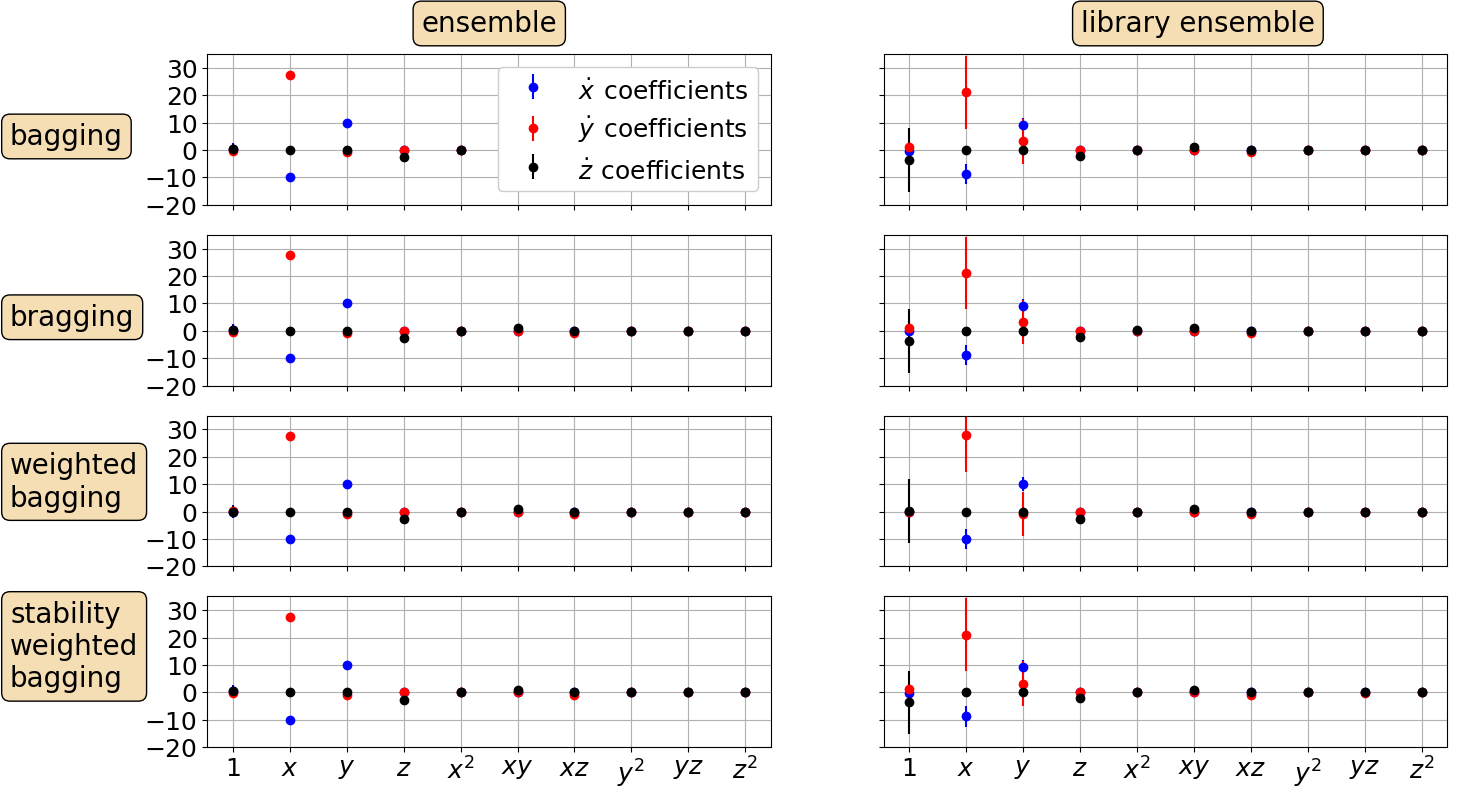

In [11]:
# Plot bagging, bragging, and other post-processing results with error bars
coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.mean(library_ensemble_coefs, axis=0), 
              e_wavg,
              l_wavg,
              np.median(ensemble_coefs, axis=0),
              np.median(library_ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
              np.mean(stable_library_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             e_wstd,
             l_wstd,
             np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
             np.std(stable_library_ensemble_coefs, axis=0), 
             ]

# define some plotting needs
colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 
            'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))

# Loop over the different post-processed coefficients
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], 
                     label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=28)
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=18, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.15, 'ensemble', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    if k == 1:
        ax.text(0.35, 1.15, 'library ensemble', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.35, 0.4, textstr, transform=ax.transAxes, 
                fontsize=20, bbox=props)
    else:
        ax.set_yticklabels([])

### Repeat ensembling but now make ~1000 models and plot the distributions of coefficients

In [12]:
%%time
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=1000, quiet=True)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

(x)' = -10.023 x + 10.013 y
(y)' = 27.808 x + -0.930 y + -0.996 x z
(z)' = -2.663 z + 0.998 x y
CPU times: user 8.28 s, sys: 7.9 ms, total: 8.29 s
Wall time: 8.29 s


In [13]:
%%time
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=1000, quiet=True)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)

(x)' = -10.023 x + 10.013 y
(y)' = 27.808 x + -0.930 y + -0.996 x z
(z)' = 0.169 1 + -2.669 z + 0.998 x y
CPU times: user 7.1 s, sys: 3.68 ms, total: 7.1 s
Wall time: 7.1 s


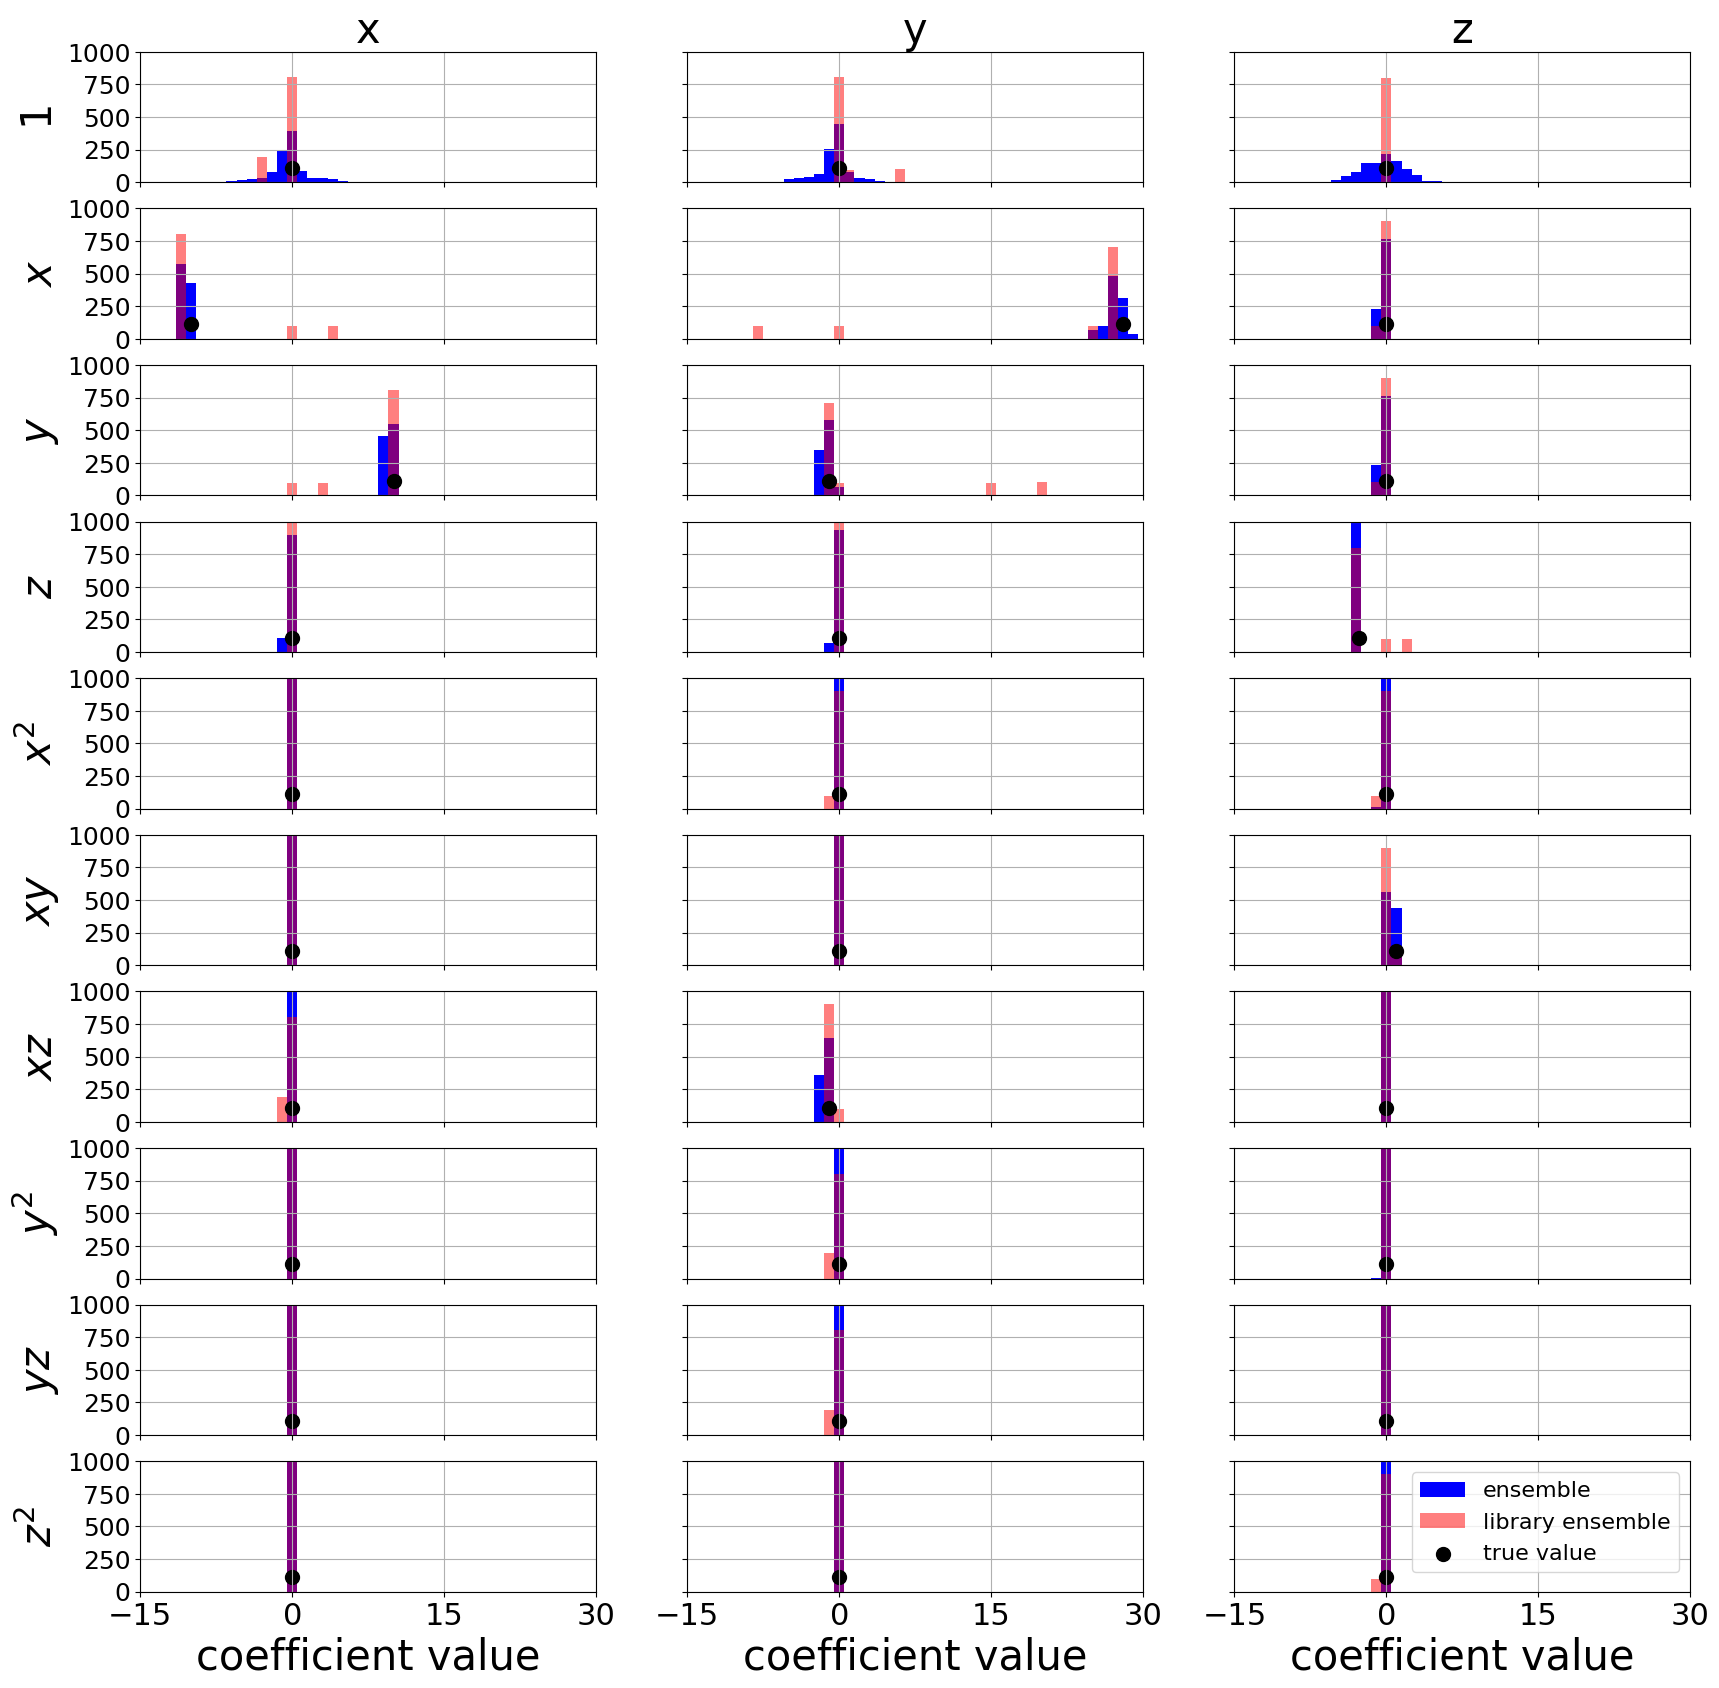

In [14]:
# Make plots of each coefficient distribution!
plt.figure(figsize=(20, 20))
min_overall = -15
max_overall = 30
true_coefs = np.asarray([[0, -10, 10, 0, 0, 0, 0, 0, 0, 0],
                         [0, 28.0, -1, 0, 0, 0, -1, 0, 0, 0],
                         [0, 0, 0, -8.0 / 3.0, 0, 1, 0, 0, 0, 0]])

# Loop through each element in the coefficients
for j in range(10):
    for i in range(3):
        plt.subplot(10, 3, i + 1 + j * 3)
        if j == 0:
            plt.title(feature_names[i], fontsize=30)
        bins = np.linspace(min_overall, max_overall, max_overall - min_overall + 1)
        plt.hist(ensemble_coefs[:, i, j], color='b', bins=bins, 
                 label='ensemble', align='left')
        plt.hist(library_ensemble_coefs[:, i, j], bins=bins, 
                 color='r', alpha=0.5, label='library ensemble', align='left')
        plt.scatter(true_coefs[i, j], 110.0, color='k', 
                    label='true value', s=100, marker='o')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(xticknames[j], fontsize=30)
        else:
            ax.set_yticklabels([])
        if j != 9:
            ax.set_xticklabels([])
        else:
            plt.xlabel('coefficient value', fontsize=30)
        ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.ylim(0, 1000)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=18)
        if i == 2 and j == 9:
            plt.legend(fontsize=16)

### Plot 95% percentile bounds with mean and median test trajectories 

In [15]:
%%time
# Rerun the ensembling
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=100, quiet=True)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

(x)' = -10.023 x + 10.013 y
(y)' = 27.808 x + -0.930 y + -0.996 x z
(z)' = 0.169 1 + -2.669 z + 0.998 x y
CPU times: user 918 ms, sys: 7.93 ms, total: 926 ms
Wall time: 924 ms


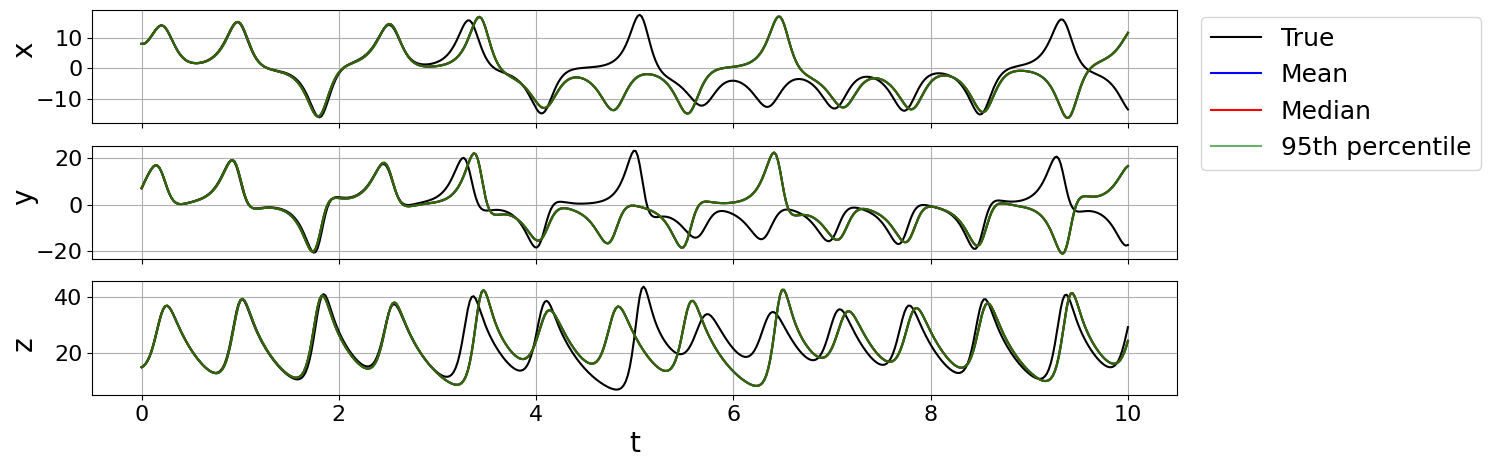

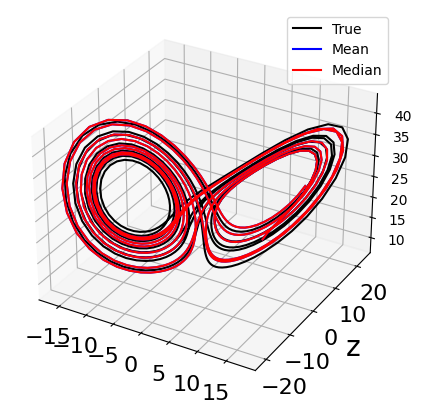

In [16]:
%%time
mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
median_ensemble_coefs = np.median(ensemble_coefs, axis=0)

# Predict the testing trajectory with the mean and median models
t_test = np.linspace(0, 10, 500)
t_test_span = (t_test[0], t_test[-1])
x_test_sim = solve_ivp(lorenz, t_test_span, x0_test, 
                       t_eval=t_test, **integrator_keywords).y.T  
ensemble_optimizer.coef_ = mean_ensemble_coefs
x_test_sim_mean = model.simulate(x0_test, t_test)
ensemble_optimizer.coef_ = median_ensemble_coefs
x_test_sim_median = model.simulate(x0_test, t_test)

# Predict the testing trajectory with all the models
x_test_sims = []
for i in range(ensemble_coefs.shape[0]):
    ensemble_optimizer.coef_ = ensemble_coefs[i, :, :]
    x_test_sims.append(model.simulate(x0_test, t_test))

# Compute the 2.5 and 97.5 percentile trajectories
bottom_line = np.percentile(x_test_sims, 2.5, axis=0)
top_line = np.percentile(x_test_sims, 97.5, axis=0)

# Plot trajectory results
plt.figure(figsize=(14, 5))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_test, x_test_sim[:, i], 'k', label='True')
    plt.plot(t_test, x_test_sim_mean[:, i], 'b', label='Mean')
    plt.plot(t_test, x_test_sim_median[:, i], 'r', label='Median')
    plt.plot(t_test, bottom_line[:, i], 'g', alpha=0.6, label='95th percentile')
    plt.plot(t_test, top_line[:, i], 'g', alpha=0.6)
    ax = plt.gca()
    ax.fill_between(t_test, bottom_line[:, i], top_line[:, i], color='g', alpha=0.3)
    plt.grid(True)
    if i != 2:
        ax.set_xticklabels([])
    else:
        plt.xlabel('t', fontsize=20)
    plt.ylabel(feature_names[i], fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.set_label_coords(-0.05, 0.75 - 0.1 * (i + 1))
    if i == 0:
        ax.legend(bbox_to_anchor=(1.01, 1.05), fontsize=18)

# Plot 3D trajectory results
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111, projection='3d')
plt.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'k', label='True')
plt.plot(x_test_sim_mean[:, 0], x_test_sim_mean[:, 1], x_test_sim_mean[:, 2], 
         'b', label='Mean')
plt.plot(x_test_sim_median[:, 0], x_test_sim_median[:, 1], 
         x_test_sim_median[:, 2], 'r', label='Median')
plt.grid(True)
plt.ylabel(feature_names[i], fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

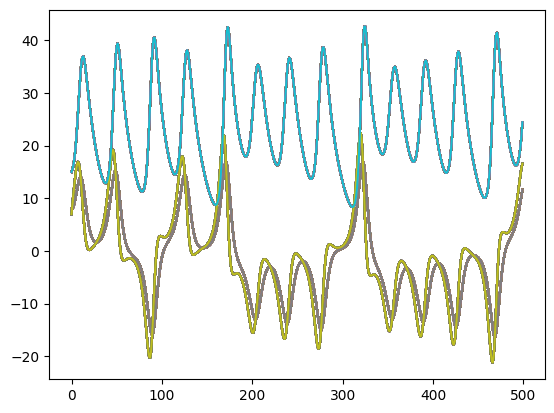

In [17]:
for x in x_test_sims:
    plt.plot(x)

### Variant of library ensembling (P5): 
1. Library ensemble and calculate inclusion probabilities
2. Threshold off library terms below some threshold probability
3. Run normal ensemble method with reduced library

This works with similar success with pure ensembling, but this can be very helpful for more complicated, higher-dimensional systems with many library terms.

(x)' = -10.023 x + 10.013 y
(y)' = 0.279 1 + 25.517 x + -0.951 x z
(z)' = 0.169 1 + -2.669 z + 0.998 x y
CPU times: user 304 ms, sys: 8.01 ms, total: 312 ms
Wall time: 308 ms


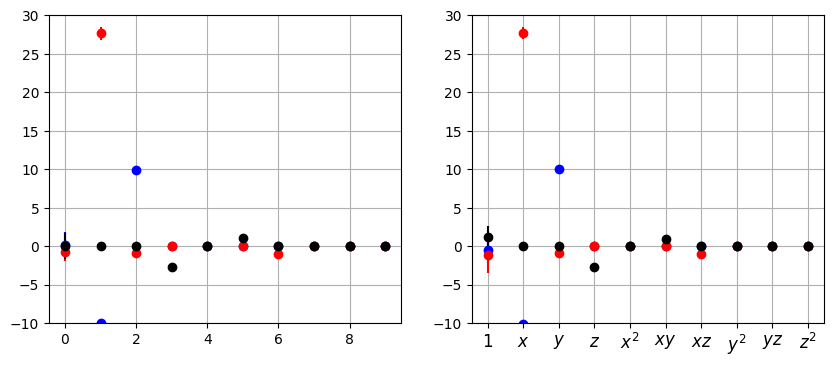

In [18]:
%%time
# 1. Library ensemble and calculate inclusion probabilities
n_candidates_to_drop = 1
n_models = 10
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=n_models, 
          n_candidates_to_drop=n_candidates_to_drop, quiet=True)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)
n_targets = len(feature_names)
n_features = len(model.get_feature_names())

# Calculate inclusion probabilities (note you may want to add another factor here because 
# each term is only present for a portion of the fits)
inclusion_probabilities = np.count_nonzero(model.coef_list, axis=0) / n_models

# 2. Chop inclusion probabilities <= 50% (this is rather drastic for illustration)
inclusion_probabilities[inclusion_probabilities <= 0.3] = 0.0

# Find indices that are chopped for all three equations
# since we pass the same library for all.
chopped_inds = np.any(inclusion_probabilities != 0.0, axis=0)
chopped_inds = np.ravel(np.where(~chopped_inds))

# 3. Pass truncated library and then do normal ensembling
library = ps.PolynomialLibrary(degree=2, library_ensemble=True, 
                               ensemble_indices=chopped_inds)
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(
    feature_names=feature_names, 
    optimizer=ensemble_optimizer, 
    feature_library=library
)
model.fit(x_train, t=dt, ensemble=True, n_models=n_models, quiet=True)
two_step_ensemble_coefs = np.asarray(model.coef_list)
two_step_mean = np.mean(two_step_ensemble_coefs, axis=0)
two_step_std = np.std(two_step_ensemble_coefs, axis=0)
two_step_median = np.median(two_step_ensemble_coefs, axis=0)

# Add zeros to get coefficient matrices to original full size
for i in range(len(chopped_inds)):
    two_step_mean = np.insert(two_step_mean, chopped_inds[i], 0.0, axis=-1)
    two_step_std = np.insert(two_step_std, chopped_inds[i], 0.0, axis=-1)
    two_step_median = np.insert(two_step_median, chopped_inds[i], 0.0, axis=-1)

# Compare with pure ensembling 
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=n_models, quiet=True)
ensemble_coefs = np.asarray(model.coef_list)
one_step_mean = np.mean(ensemble_coefs, axis=0)
one_step_std = np.std(ensemble_coefs, axis=0)
one_step_median = np.median(ensemble_coefs, axis=0)

# Plot results
colors = ['b', 'r', 'k']
xticknames = model.get_feature_names()
for i in range(10):
    xticknames[i] = '$' + xticknames[i] + '$'
plt.figure(figsize=(10, 4))
for i in range(n_targets):
    plt.subplot(1, 2, 1)
    plt.errorbar(range(n_features), 
                 two_step_mean[i, :], 
                 yerr=two_step_std[i, :], 
                 fmt='o', 
                 color=colors[i])
    plt.grid(True)
    plt.ylim(-10, 30)
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=12)
    plt.subplot(1, 2, 2)
    plt.errorbar(range(n_features), 
                 one_step_mean[i, :], 
                 yerr=one_step_std[i, :], 
                 fmt='o', color=colors[i])
    plt.grid(True)
    plt.ylim(-10, 30)
    
    ax = plt.gca()
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=12)

### Generate achievability plots from Maddu et al. 2019
Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810.

For these plots, we want to do the following:
1. Ensemble and calculate inclusion probabilities
2. Threshold off library terms below some threshold probability
3. If there exists some $\lambda$ threshold such that the resulting reduced library is the correct support for the Lorenz equation, this is counted as success, otherwise failure. 

In [19]:
%%time
# Support for the Lorenz coefficients
support_lorenz = np.zeros((3, 10))
support_lorenz[0, 1] = 1.0
support_lorenz[0, 2] = 1.0
support_lorenz[1, 1] = 1.0
support_lorenz[1, 2] = 1.0
support_lorenz[1, 6] = 1.0
support_lorenz[2, 3] = 1.0
support_lorenz[2, 5] = 1.0

# Scan over threshold, noise level, number of time samples, 
# and number of initial conditions.
lambda_scan = np.linspace(0.01, 0.1, 10)
noise_scan = np.linspace(0, rmse / 10.0, 10)
sampling_scan = range(40, 400, 40)
ic_scan = (np.random.rand(10, 3) - 0.5) * 20

# Fix number of models to generate
n_models = 10

success_rates = np.zeros((10, len(sampling_scan), 10))

dt = .005
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
for kk, ic in enumerate(ic_scan):
    x_train = solve_ivp(lorenz, t_train_span, ic, 
                        t_eval=t_train, **integrator_keywords).y.T
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    print(kk)
    for j, noise in enumerate(noise_scan):
        x_noisy = x_train + np.random.normal(0, noise)
        for i, sample in enumerate(sampling_scan):
            for k, lam in enumerate(lambda_scan):
                ensemble_optimizer = ps.STLSQ(threshold=lam)
                model = ps.SINDy(feature_names=feature_names, 
                                 optimizer=ensemble_optimizer)
                model.fit(x_noisy, t=dt, ensemble=True, n_models=n_models, 
                          n_subset=sample, quiet=True)
                inclusion_probabilities = np.count_nonzero(
                    model.coef_list, axis=0
                ) / n_models
                inclusion_probabilities[inclusion_probabilities <= 0.8] = 0.0
                if np.allclose(support_lorenz, inclusion_probabilities, atol=1e-3):
                    success_rates[kk, i, j] = 1.0
                    continue

0
1
2
3
4
5
6
7
8
9
CPU times: user 5min 55s, sys: 127 ms, total: 5min 56s
Wall time: 5min 55s


Text(0, 0.5, 'Number of time samples per model')

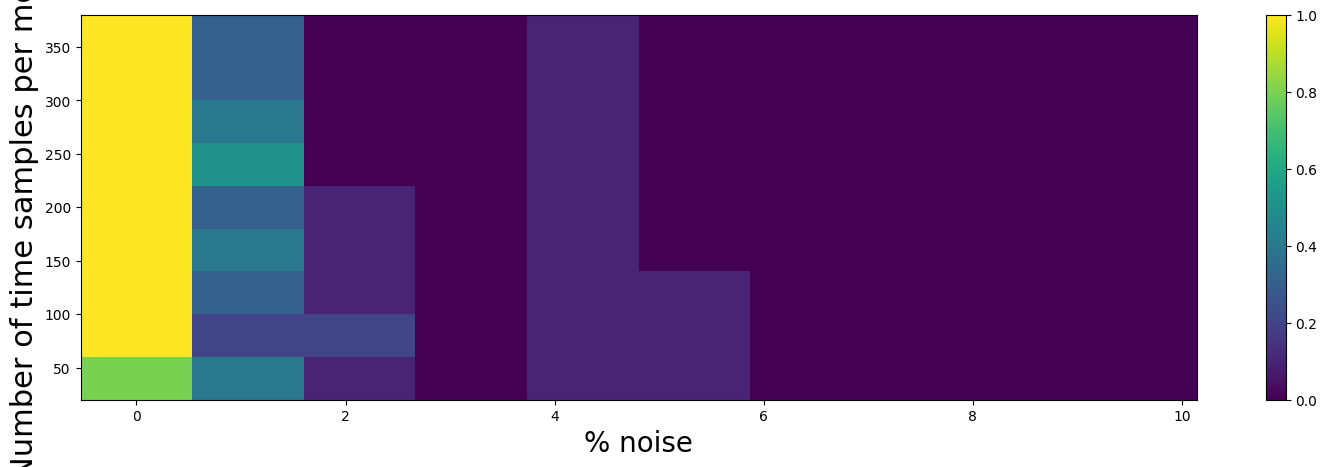

In [20]:
successes = np.mean(success_rates, axis=0)
plt.figure(figsize=(18, 5))
plt.pcolormesh(noise_scan / rmse * 100, sampling_scan, successes)
plt.colorbar()
plt.xlabel('% noise', fontsize=20)
plt.ylabel('Number of time samples per model', fontsize=22)

### Test ensemble functionality with weak-PDE functionality, using the Kuramoto-Sivashinsky equation. For understanding weak form use, please see the Example 14 Jupyter Notebook.
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

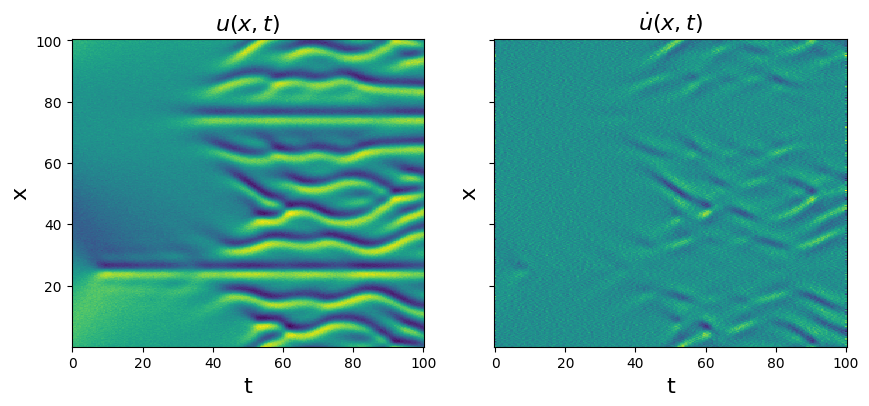

In [21]:
from scipy.io import loadmat 

data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']

# add 5% noise
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 10.0, u.shape)
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u = u.reshape(len(x), len(time), 1)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot[:, :, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [22]:
train = range(0, int(len(time) * 0.6))
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train, :]
u_test = u[:, test, :]
u_dot_train = u_dot[:, train, :]
u_dot_test = u_dot[:, test, 0]
t_train = time[train]
t_test = time[test]

X, T = np.meshgrid(x, t_train)
XT = np.asarray([X, T]).T

# Define PDE library that is quadratic in u, and 
# fourth-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    include_bias=True,
    is_uniform=False,
    periodic=True
)

In [23]:
%%time
# Run SR3 with L0 norm
n_models = 10
optimizer = ps.SR3(threshold=2, max_iter=100, tol=1e-3, 
                   thresholder='l0', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, ensemble=True, 
          n_models=n_models, n_subset=len(time) // 2, quiet=True)

model.print()

# Aggregate, average, and take median of the coefficients
weak_KS_models = np.asarray(model.coef_list)
mean_weak_KS_models = np.mean(weak_KS_models, axis=0)
median_weak_KS_models = np.median(weak_KS_models, axis=0)
print('Mean of KS models: ', mean_weak_KS_models)
print('Median of KS models: ', median_weak_KS_models)

(x0)' = -1.001 x0_11 + -1.003 x0_1111 + -1.000 x0x0_1
Mean of KS models:  [[ 0.          0.          0.          0.         -1.00419741  0.
  -1.00535937 -1.00006721  0.          0.          0.          0.
   0.          0.          0.        ]]
Median of KS models:  [[ 0.          0.          0.          0.         -1.00563154  0.
  -1.00563835 -1.00112556  0.          0.          0.          0.
   0.          0.          0.        ]]
CPU times: user 179 ms, sys: 16 ms, total: 195 ms
Wall time: 193 ms


In [24]:
negligible_val = 1e-2

# Simple definition of a model error, ||True - Pred|| / ||True||
def model_error(KS_pred_coef, KS_true_coef):
    return np.linalg.norm(KS_true_coef - KS_pred_coef
                         ) / np.linalg.norm(KS_true_coef)

# Returns 1 if the identified model has three coefficient 
# entries in the right locations. Otherwise returns 0. 
def success_rate(KS_pred_coef, KS_true_coef):
    return np.all(
        (abs(KS_true_coef) > negligible_val) == (abs(KS_pred_coef) > negligible_val)
    )

In [25]:
print(model.get_feature_names())
KS_true = np.zeros((1, 15))
KS_true[0, 4] = -1.0
KS_true[0, 6] = -1.0
KS_true[0, 7] = -1.0
print('mean: ', model_error(mean_weak_KS_models, KS_true), 
      success_rate(mean_weak_KS_models, KS_true))
print('median: ', model_error(median_weak_KS_models, KS_true), 
      success_rate(median_weak_KS_models, KS_true))

total_model_error = []
total_success_rate = []
for i in range(n_models):
    coef = weak_KS_models[i, :, :]
    total_model_error.append(model_error(coef, KS_true))
    total_success_rate.append(success_rate(coef, KS_true))
    print(i, model_error(coef, KS_true), success_rate(coef, KS_true))
    
print('Average model error: ', np.mean(total_model_error, axis=0) * 100, '%')
print('Average success rate: ', np.mean(total_success_rate, axis=0) * 100, '%')

['1', 'x0', 'x0x0', 'x0_1', 'x0_11', 'x0_111', 'x0_1111', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11', 'x0x0_111', 'x0x0x0_111', 'x0x0_1111', 'x0x0x0_1111']
mean:  0.003930464336450587 True
median:  0.00464658134247953 True
0 0.016784165386845715 True
1 0.0020985675034161507 True
2 0.008857082863800658 True
3 0.007215792042125589 True
4 0.008849668943435425 True
5 0.0032100987793613244 True
6 0.008883498869715773 True
7 0.010992195406688167 True
8 0.0032530476083923346 True
9 0.006329531217151772 True
Average model error:  0.7647364862093291 %
Average success rate:  100.0 %
